# 복습문제_따릉이

* 지금까지 배운 것을 복습 합니다.
* Data : 서울 공유 자전거
* 문제 : 2시간 후의 수요를 예측하고자 합니다.
------

* 모든게 처음이신 분들은 
    * 알고리즘을 사용하고 익히는 것에 초점을 맞추시고
    * 다양한 알고리즘으로 만든 모델에 대해 성능 비교를 수행합니다.
* 경험이 있으신 분들은
    * 각 알고리즘마다 최고의 성능을 얻기 위해 노력해 보세요.
    * 필요하다면 적절한 feature engineering도 수행합니다.
    * 수행시간이 오래 걸리는 알고리즘(SVM, RandomForest, XGB, DL)에 대해서는 학습데이터 크기를 조절해 봅시다.(learning_curve 이용)
    * 과적합에 대한 평가와 회피하기 위한 시도를 해보세요.
    * 그리고 정리한 자신 만의 내용을 github에 올려서 다른 에이블러들과 공유해 봅시다.^^ 
-----


* **진행시 주의사항**
    * 본 복습문제 수행 여부는 **개인 자유** 입니다. 제출받는 것이 아니니 부담갖지 않으셔도 좋습니다.
    * 본 복습문제를 수행하는 도중 발생된 질문은 
        * **1:1게시판이나 수업중 채팅으로 질문하지 말고** (튜터님들은 모르고 계십니다.^^;;;)
        * 문제 해결을 위해, 과정 자료, 인터넷 검색 등을 통해 **스스로 해결** 해 봅니다. 
        * 특히 https://stackoverflow.com/ 는 개발자들이 참여하는 굉장히 큰 Q&A 사이트입니다. 거의 대부분의 문답은 여기에 다 있습니다. 적극 활용하세요. **스스로 문제 해결하는 연습** 은 굉장히 중요합니다.
        * 그럼에도 불구하고 도저히 해결이 안될 때, **최후의 히든 카드** 로 저에게 이메일 문의를 하시면, 제가 시간이 가용할때 순차적으로 답변을 드리겠습니다.^^

![](https://mediahub.seoul.go.kr/uploads/mediahub/2021/03/RaKqiqgRXyNmYVYymXQIvCjPHpncuhBX.png)

## 1.환경준비

### (1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

### (2) 데이터로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBikeData2.csv'
data = pd.read_csv(path)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Visibility,Solar,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,2017-12-01 00:00:00,254,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes


**변수설명**  

* DateTime : year-month-day hh:mi:ss
* Count : 시간대별 수요량
* Temperature : 온도(섭씨)
* Humidity : 습도(%)
* WindSpeed : 풍속(m/s)
* Visibility : 가시거리(단위: 10m)
* Solar - 태양복사열, MJ/m2
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday / No holiday
* FuncDay - Yes / No


In [4]:
# 데이터 기간은 다음과 같습니다.
data.DateTime.min(), data.DateTime.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 23:00:00'))

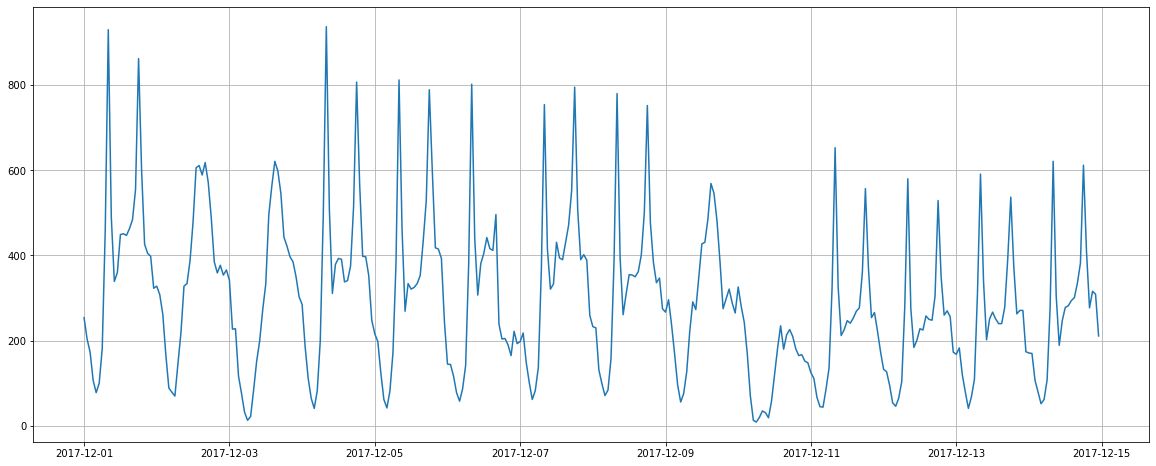

In [5]:
# 14일 동안의 수요량을 살펴 봅시다.
temp = data[:24*14]
plt.figure(figsize = (20,8))
plt.plot('DateTime', 'Count', data = temp)
plt.grid()
plt.show()

## 2.데이터 준비

### (1) y 만들기 
* 2시간 이후의 수요량을 예측해야 합니다.

In [6]:
data['y'] = data['Count'].shift(-2)
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Visibility,Solar,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
0,2017-12-01 00:00:00,254,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,173.0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,107.0
2,2017-12-01 02:00:00,173,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,78.0
3,2017-12-01 03:00:00,107,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,100.0
4,2017-12-01 04:00:00,78,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,181.0


In [7]:
# 2칸을 앞당겼기 때문에 하위 2행의 y값에 NaN이 표시되어 있습니다.
data.tail()

,DateTime,Count,Temperature,Humidity,WindSpeed,Visibility,Solar,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
8755,2018-11-30 19:00:00,1003,4.2,34,2.6,1894,0.0,0.0,0.0,Autumn,No Holiday,Yes,694.0
8756,2018-11-30 20:00:00,764,3.4,37,2.3,2000,0.0,0.0,0.0,Autumn,No Holiday,Yes,712.0
8757,2018-11-30 21:00:00,694,2.6,39,0.3,1968,0.0,0.0,0.0,Autumn,No Holiday,Yes,584.0
8758,2018-11-30 22:00:00,712,2.1,41,1.0,1859,0.0,0.0,0.0,Autumn,No Holiday,Yes,NaN
8759,2018-11-30 23:00:00,584,1.9,43,1.3,1909,0.0,0.0,0.0,Autumn,No Holiday,Yes,NaN


In [8]:
# 하위 2행은 삭제합니다.
# 하위 2행 제외하고 다시 붓기
data = data[:-2]

### (2) 데이터 분할1 : x, y 나누기

In [9]:
target = 'y'
x = data.drop(target, axis=1)
y = data[target]

### (3) feature engineering
* 이 부분은 넘어가셔도 좋습니다.
* 다만 DataTime은 제거합니다.

In [10]:
# 날짜 데이터 제거
x.drop('DateTime', axis=1, inplace=True)
x.head()

,Count,Temperature,Humidity,WindSpeed,Visibility,Solar,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,254,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
1,204,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
2,173,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
3,107,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes
4,78,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes


### (4) NaN 조치

### (5) 가변수화

In [11]:
col_cat = ['Seasons', 'Holiday', 'FuncDay']
x = pd.get_dummies(x, columns = col_cat, drop_first = True)

In [12]:
x.head()

,Count,Temperature,Humidity,WindSpeed,Visibility,Solar,Rainfall,Snowfall,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,FuncDay_Yes
0,254,-5.2,37,2.2,2000,0.0,0.0,0.0,0,0,1,1,1
1,204,-5.5,38,0.8,2000,0.0,0.0,0.0,0,0,1,1,1
2,173,-6.0,39,1.0,2000,0.0,0.0,0.0,0,0,1,1,1
3,107,-6.2,40,0.9,2000,0.0,0.0,0.0,0,0,1,1,1
4,78,-6.0,36,2.3,2000,0.0,0.0,0.0,0,0,1,1,1


### (6) 데이터분할2 : train : val

* 시계열 데이터이므로 시간의 흐름에 맞게 분할합시다.
* 뒤에서 30일 : validaiton
* 나머지 : train
* 30일 : 시간단위 데이터이므로 24 * 30
* train_test_split(x, y, test_size = 24 * 30, shuffle = False)
    * shuffle : 데이터를 섞을지, 아니면 있는 그대로 자를지 결정.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 24 * 30, shuffle = False)

### (7) Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
x_train_1 = scaler.fit_transform(x_train)
x_val_1 = scaler.transform(x_val)

## 3.모델링
* 배운 알고리즘을 적용하여 모델링을 수행하고 성능을 비교합니다.

### (1) 선형회귀

In [52]:
# 모델링용
from sklearn.linear_model import LinearRegression

# 회귀모델 평가용
from sklearn.metrics import *

In [53]:
# 모델 생성 및 학습
model_LR = LinearRegression()
model_LR.fit(x_train, y_train)

print('LinearRegression')
print(model_LR.coef_, model_LR.intercept_)

LinearRegression
[ 5.88067533e-01  6.78640689e+00 -9.62383240e-01  6.89614343e+00
 -6.64686637e-03  1.59711988e+02 -1.25274246e+01  9.88500506e+00
 -1.01055842e+02 -7.77682287e+01 -1.57672682e+02  6.27350770e+01
  3.54827695e+02] -149.70890265337925


In [54]:
# 모델 예측
pred_LR = model_LR.predict(x_val)

In [55]:
# 모델 평가
print(mean_squared_error(y_val, pred_LR, squared=False))
print(mean_absolute_error(y_val, pred_LR))
print(mean_absolute_percentage_error(y_val, pred_LR))

350.45552729631294
243.51357364541965
7.456335594929048e+16


### (2) KNN

In [15]:
from sklearn.neighbors import KNeighborsRegressor

In [42]:
knn = KNeighborsRegressor(n_neighbors=20, metric='euclidean')

In [43]:
knn.fit(x_train_1, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=20)

In [44]:
pred_knn = knn.predict(x_val_1)

In [45]:
# 모델 평가
print(mean_squared_error(y_val, pred_knn, squared=False))
print(mean_absolute_error(y_val, pred_knn))
print(mean_absolute_percentage_error(y_val, pred_knn))

353.6959503221737
261.343125
4.888563570518437e+16


### (3) Decision Tree

### (4) SVM
* svm은 모델링 시간이 오래 걸립니다.

### (5) Random Forest

### (6) XGB

### (7) SARIMAX

### (8) Deep Learning
* 딥러닝 모델링은 이번 머신러닝 과정 안에 포함되지 않습니다. 추후에 배우신 다음에 시도해보세요.
* 시도해볼 만한 방식
    * DNN
    * CNN(Conv1d)
    * RNN(LSTM)

### (9) 그외 추가 알고리즘